In [10]:
# =========================================
# 1. Imports and Data Loading
# =========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 200)
sns.set(style="whitegrid")

# ---- CHANGE THIS TO YOUR FILE NAME ----
df = pd.read_csv("hackathon_dataset.csv")  # e.g. "train.csv" or whatever your file is
# ---------------------------------------

print(df.head())
print(df.info())
print(df.describe(include="all"))

     cust_id        age gender marital_status employment_status        income  \
0  SYN000000  42.551758      F        Married     Self-Employed  3.259826e+06   
1  SYN000001  29.309474      F         Single     Self-Employed  3.430405e+06   
2  SYN000002  46.941237      F        Married     Self-Employed  4.761488e+06   
3  SYN000003  48.813428      M        Married          Salaried -5.066831e+05   
4  SYN000004  20.337669      M         Single          Salaried  3.051567e+06   

   number_of_dependants residence_type  years_at_current_address     city  \
0              3.476813         Rented                 17.160243  Lucknow   
1              1.993254       Mortgage                 11.043814  Chennai   
2              3.949298          Owned                 24.536740   Jaipur   
3              3.244730          Owned                 20.970346  Lucknow   
4              3.390047          Owned                 32.880164  Chennai   

           state        zipcode loan_id loan_purpo

In [12]:
# Determine the correct target column dynamically
# ----------------------------------------------
import os

# Ensure df is available (try to load if not)
if 'df' not in globals():
    csv_path = "hackathon_dataset.csv"
    if os.path.exists(csv_path):
        import pandas as pd
        df = pd.read_csv(csv_path)
        print(f"Loaded '{csv_path}' into df")
    else:
        raise NameError("DataFrame 'df' is not defined and 'hackathon_dataset.csv' not found. Run the data-loading cell or place the CSV in the workspace.")

# Try common target column names and pick the first match
possible_targets = ["default_flag", "default", "is_default", "target"]
TARGET_COL = next((c for c in possible_targets if c in df.columns), None)

if TARGET_COL is None:
    raise ValueError(f"No expected target column found. Available columns: {df.columns.tolist()}")

print(f"Using TARGET_COL = '{TARGET_COL}'")
print(df[TARGET_COL].value_counts(dropna=False))

# Missing values overview
print(df.isna().sum().sort_values(ascending=False))

Using TARGET_COL = 'default'
default
 0.648933    1
-0.266155    1
 0.091832    1
 0.059348    1
 0.094404    1
            ..
 0.376283    1
 0.218120    1
 0.702962    1
-0.361524    1
 0.375397    1
Name: count, Length: 35000, dtype: int64
residence_type                 1750
loan_purpose                   1750
cust_id                           0
marital_status                    0
age                               0
employment_status                 0
income                            0
number_of_dependants              0
gender                            0
years_at_current_address          0
city                              0
zipcode                           0
state                             0
loan_id                           0
loan_type                         0
sanction_amount                   0
loan_amount                       0
processing_fee                    0
gst                               0
net_disbursement                  0
loan_tenure_months                0
p

In [9]:

num_columns_expected = [
    "age",
    "income",
    "loan_amount",
    "emi",
    "processing_fee",
    "current_balance",
    "credit_utilization",
    "tenure"
]
# -----------------------------------------------

for col in num_columns_expected:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
# Drop rows with impossible negative values for key numeric fields
for col in ["age", "income", "loan_amount", "emi", "processing_fee", "current_balance", "tenure"]:
    if col in df.columns:
        df = df[df[col].isna() | (df[col] >= 0)]

# Simple imputation for numeric: median
for col in df.select_dtypes(include=["number"]).columns:
    if col != TARGET_COL:
        df[col] = df[col].fillna(df[col].median())

# Simple imputation for categoricals: "Unknown"
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = df[col].fillna("Unknown")

print("After cleaning:")
print(df.info())

After cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 17149 entries, 0 to 34999
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cust_id                      17149 non-null  object 
 1   age                          17149 non-null  float64
 2   gender                       17149 non-null  object 
 3   marital_status               17149 non-null  object 
 4   employment_status            17149 non-null  object 
 5   income                       17149 non-null  float64
 6   number_of_dependants         17149 non-null  float64
 7   residence_type               17149 non-null  object 
 8   years_at_current_address     17149 non-null  float64
 9   city                         17149 non-null  object 
 10  state                        17149 non-null  object 
 11  zipcode                      17149 non-null  float64
 12  loan_id                      17149 non-null  object 
 13  loan_

In [11]:
if {"loan_amount", "income", "emi"}.issubset(df.columns):
    df["LTI"] = df["loan_amount"] / (df["income"] + 1e-6)
    df["emi_to_income"] = df["emi"] / (df["income"] + 1e-6)

# Processing fee percentage and flags
if {"processing_fee", "loan_amount"}.issubset(df.columns):
    df["processing_fee_pct"] = df["processing_fee"] / (df["loan_amount"] + 1e-6)
    df["fee_gt_3pct"] = (df["processing_fee_pct"] > 0.03).astype(int)
    df["fee_gt_loan"] = (df["processing_fee"] > df["loan_amount"]).astype(int)

# Credit utilization buckets
if "credit_utilization" in df.columns:
    bins = [0, 0.3, 0.6, 0.9, 10]
    labels = ["<30%", "30-60%", "60-90%", ">90%"]
    df["utilization_bucket"] = pd.cut(df["credit_utilization"], bins=bins, labels=labels, include_lowest=True)

# Age buckets
if "age" in df.columns:
    bins = [0, 25, 35, 45, 120]
    labels = ["<25", "25-35", "35-45", "45+"]
    df["age_bucket"] = pd.cut(df["age"], bins=bins, labels=labels, include_lowest=True)

print("Feature engineering done. Sample:")
print(df.head())

Feature engineering done. Sample:
     cust_id        age gender marital_status employment_status        income  \
0  SYN000000  42.551758      F        Married     Self-Employed  3.259826e+06   
1  SYN000001  29.309474      F         Single     Self-Employed  3.430405e+06   
2  SYN000002  46.941237      F        Married     Self-Employed  4.761488e+06   
7  SYN000007  36.436701      F         Single          Salaried  5.030699e+06   
9  SYN000009  31.150415      F        Married          Salaried  4.577777e+06   

   number_of_dependants residence_type  years_at_current_address       city  \
0              3.476813         Rented                 17.160243    Lucknow   
1              1.993254       Mortgage                 11.043814    Chennai   
2              3.949298          Owned                 24.536740     Jaipur   
7              1.473651          Owned                 14.433754      Delhi   
9              0.813575         Rented                 17.598624  Bangalore   

    

In [13]:

numeric_for_eda = [
    "loan_amount",
    "emi",
    "LTI",
    "emi_to_income",
    "processing_fee_pct",
    "credit_utilization",
    "current_balance"
]

for col in numeric_for_eda:
    if col in df.columns:
        # KDE plot
        plt.figure(figsize=(7, 4))
        sns.kdeplot(data=df, x=col, hue=TARGET_COL, common_norm=False, fill=True)
        plt.title(f"Distribution of {col} by {TARGET_COL}")
        plt.tight_layout()
        plt.show()

        # Boxplot
        plt.figure(figsize=(6, 4))
        sns.boxplot(data=df, x=TARGET_COL, y=col)
        plt.title(f"{col} vs {TARGET_COL}")
        plt.tight_layout()
        plt.show()

ValueError: Could not interpret value `default_flag` for `hue`. An entry with this name does not appear in `data`.

<Figure size 700x400 with 0 Axes>

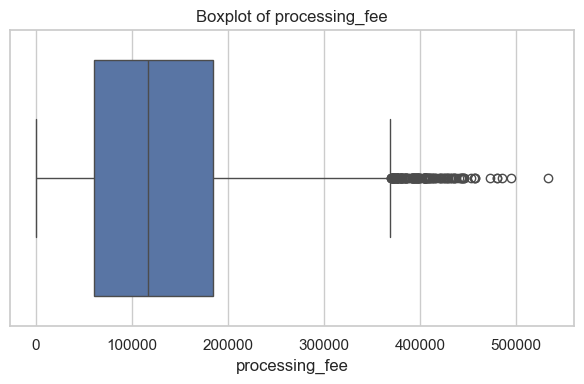

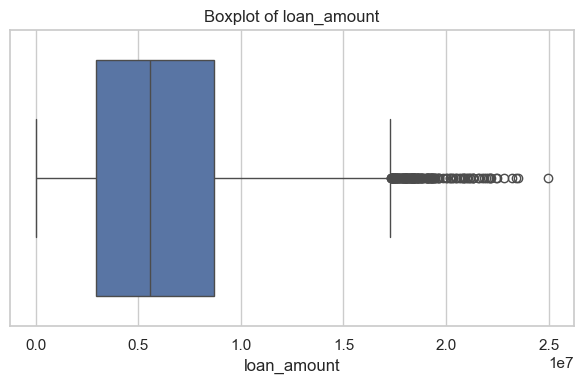

In [15]:
outlier_cols = ["processing_fee", "loan_amount", "emi", "credit_utilization", "current_balance", "tenure"]
for col in outlier_cols:
    if col in df.columns:
        plt.figure(figsize=(6, 4))
        sns.boxplot(data=df, x=col)
        plt.title(f"Boxplot of {col}")
        plt.tight_layout()
        plt.show()

# Default rate by anomaly flags if they exist
if TARGET_COL in df.columns and "fee_gt_3pct" in df.columns:
    print("Default rate by fee_gt_3pct:")
    print(df.groupby("fee_gt_3pct")[TARGET_COL].mean(numeric_only=True))

if TARGET_COL in df.columns and "fee_gt_loan" in df.columns:
    print("Default rate by fee_gt_loan:")
    print(df.groupby("fee_gt_loan")[TARGET_COL].mean(numeric_only=True))

In [17]:
categorical_for_eda = ["utilization_bucket", "age_bucket", "city_tier", "employment_type", "customer_segment"]
for col in categorical_for_eda:
    if col in df.columns:
        rates = df.groupby(col)[TARGET_COL].mean(numeric_only=True)
        plt.figure(figsize=(7, 4))
        rates.sort_values().plot(kind="bar")
        plt.ylabel("Default rate")
        plt.title(f"Default rate by {col}")
        plt.tight_layout()
        plt.show()
        print(f"\nDefault rate by {col}:")
        print(rates)

C:\Users\91636\AppData\Local\Temp\ipykernel_15932\510726398.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rates = df.groupby(col)[TARGET_COL].mean(numeric_only=True)


KeyError: 'Column not found: default_flag'

In [19]:
print("\n=== Numeric feature differences (mean by target) ===")
for col in numeric_for_eda:
    if col in df.columns:
        mean_bad = df.loc[df[TARGET_COL] == 1, col].mean()
        mean_good = df.loc[df[TARGET_COL] == 0, col].mean()
        print(f"{col}: mean(default=1)={mean_bad:.3f}, mean(default=0)={mean_good:.3f}")

print("\n=== Categorical feature default rates ===")
for col in categorical_for_eda:
    if col in df.columns:
        print(f"\n{col}:")
        print(df.groupby(col)[TARGET_COL].mean(numeric_only=True))


=== Numeric feature differences (mean by target) ===


KeyError: 'default_flag'

In [25]:
if {"emi_to_income", "utilization_bucket"}.issubset(df.columns):
    # Create emi_to_income buckets
    bins = [0, 0.2, 0.4, 0.6, 1.0, 10]
    labels = ["<=20%", "20-40%", "40-60%", "60-100%", ">100%"]
    df["emi_to_income_bucket"] = pd.cut(df["emi_to_income"], bins=bins, labels=labels, include_lowest=True)

    pivot = pd.pivot_table(
        df,
        index="emi_to_income_bucket",
        columns="utilization_bucket",
        values=TARGET_COL,
        aggfunc="mean"
    )

    print("\nDefault rate heatmap: EMI/Income vs Utilization")
    print(pivot)

    plt.figure(figsize=(8, 5))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="Reds")
    plt.title("Default rate by EMI/Income bucket and Utilization bucket")
    plt.tight_layout()
    plt.show()